<div style="text-align: center; font-size: 25pt; font-weight: bold; margin: 1em 0em 1em 0em">Usages of the MCN package</div>

**Author:** Adel Nabli

# Introduction: The Multilevel Critical Node problem

We have a graph $G(V,E)$ and we want to solve a multilevel critical node problem as introduced in [1]. We use the following variables:
* $D \subset V$: set of vaccinated nodes $\quad ; \quad$ $z_v = \mathbb{1}_{\text{v is vaccinated}}$ $\quad ; \quad$ $\sum_{v \in V} z_v \leq \Omega$
* $P \subset V$: set of protected nodes $\quad ; \quad$ $x_v = \mathbb{1}_{\text{v is protected}}$ $\quad ; \quad$ $\sum_{v \in V} x_v \leq \Lambda$
* $I \subset V$: set of attacked nodes $\quad ; \quad$ $y_v = \mathbb{1}_{\text{v is attacked}}$ $\quad ; \quad$ $\sum_{v \in V} y_v \leq \Phi$
* $S \subset V$: set of saved nodes $\quad ; \quad$ $\alpha_v = \mathbb{1}_{\text{v is saved}}$

We want to solve the following trilevel problem:
<h3 align="center"> $ \underset{ \substack{z \in \{0,1\}^V \\ \sum_{v \in V} z_v \leq \Omega}}{\max} \underset{ \substack{y \in \{0,1\}^V \\ \sum_{v \in V} y_v \leq \Phi}}{\min} \underset{ \substack{x \in \{0,1\}^V \\ \alpha \in [0,1]^V}}{\max} \sum_{v \in V} \alpha_v  \\ \quad \quad  \quad \quad \text{subject to} \quad \sum_{v \in V} x_v \leq \Lambda \\ \quad  \quad \quad  \quad \quad \quad \quad \quad \quad \alpha_v \leq 1+ z_v - y_v \quad \forall v \in V \\ \quad  \quad \quad  \quad \quad \quad \quad \quad \quad \alpha_v \leq \alpha_u + x_v + z_v \quad \forall (u,v) \in E$</h3>

**Sources:**

[1] **A. Baggio, M. Carvalho, A. Lodi, A. Tramontani**, ["Multilevel Approaches for the Critical Node Problem"]( http://cerc-datascience.polymtl.ca/wp-content/uploads/2017/11/Technical-Report_DS4DM-2017-012.pdf), 2018.

# [OPTIONAL] Google colab: installing packages

If this notebook is to be run on google colab, some extra steps should be taken to properly install the needed packages.

# 1. Training the neural network to solve the MCN

In [1]:
# Import the training function
from MCN.MCN_curriculum.train import train_value_net

L:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### a) setting the variables governing the distribution of instances

In [2]:
# n_free designs the number of nodes of the graph
# that would be neither vaccinated, infected or attacked.
# It governs the range of graph's sizes we are considering
n_free_min = 4
n_free_max = 10
# Omega, Phi and Lambda are the budgets of the players
# Phi_max should be >= 1, otherwise there is no MCN problem
Omega_max = 1
Phi_max = 2
Lambda_max = 2

### b) setting the hyperparameters of the neural network

In [3]:
# h1 and h2 are the hidden dim sizes used throughout
# the neural net's architecture.
h1 = 128
h2 = 64
# the number of attention heads in the GAT
n_heads = 3
# the 'skip connection' parameter in the APPNP part
alpha = 0.1

### c) setting the parameters of the training algorithm

In [4]:
# batch size used
batch_size = 20
# Replay Memory size
memory_size = 256
# Learning rate of the optimizer
lr = 1e-4
# betas parameters of the optimizer
betas = (0.8,0.9)
# Total number of episodes
E = 120000
# The period of checking whether the value net
# under training should be saved as an expert
target_update = 100
# Value of loss under which a value net is considered
# an expert for a task
tolerance = 0.2
# Size of the validation set for each task
size_validation_data = 50
# path to the directory to pre-trained target nets
path_experts = ""

In [ ]:
# Train the neural network
value_net, experts = train_value_net(batch_size, memory_size, lr, betas, E, target_update, h1, h2, n_heads, alpha,
                                     tolerance, n_free_min, n_free_max, Omega_max, Phi_max, Lambda_max,
                                     size_validation_data, path_experts)

# 2. Using trained experts or an exact algorithm to solve an instance of MCN

### a) Generating a random instance

In [5]:
# import the function generating a random instance
from MCN.utils import generate_random_instance, plot_graph

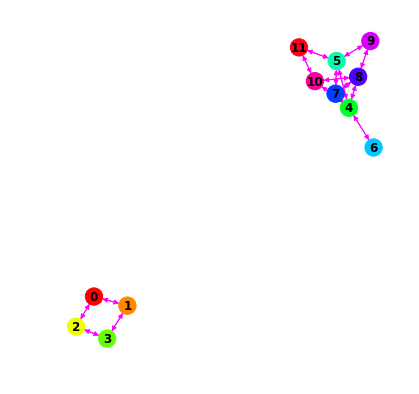

Already attacked nodes :  []
Omega : 1 ,  Phi : 2 , Lambda : 1


In [14]:
G, J, Omega, Phi, Lambda = generate_random_instance(n_free_min, n_free_max, Omega_max, Phi_max, Lambda_max)
# plots the graph
plot_graph(G)
# print the other parameters
print("Already attacked nodes : ", J)
print("Omega : %d ,  Phi : %d , Lambda : %d"%(Omega, Phi, Lambda))

### b) Solving the instance exactly

In [6]:
# import the solver
from MCN.solve_mcn import solve_mcn

In [16]:
value, D, I, P = solve_mcn(G, Omega, Phi, Lambda, J=J, exact=True)
# print the outputs
print("number of saved nodes : ", value)
print("Vaccinated nodes D: ", D)
print("Attacked nodes I : ", I)
print("Protected nodes P :", P)

number of saved nodes :  3
Vaccinated nodes D:  [4]
Attacked nodes I :  [1, 8]
Protected nodes P : [7]


### c) Solving the instance heuristically with pre-trained experts

In [7]:
# import the ValueNet object
from MCN.MCN_curriculum.value_nn import ValueNet
# import the experts loader
from MCN.utils import load_saved_experts

In [8]:
# load the models
list_experts = load_saved_experts("models/experts")

In [19]:
value, D, I, P = solve_mcn(G, Omega, Phi, Lambda, J=J,
                           Omega_max=Omega_max, Phi_max=Phi_max, Lambda_max=Lambda_max,
                           exact=False, list_experts=list_experts)
# print the outputs
# the expert nets outputs values that don't contain nodes bound to be saved
# so we add the defender's budget back to the value
print("number of saved nodes : ", value + Omega + Lambda)
print("Vaccinated nodes D: ", D)
print("Attacked nodes I : ", I)
print("Protected nodes P :", P)

number of saved nodes :  3.0
Vaccinated nodes D:  [4]
Attacked nodes I :  [8, 1]
Protected nodes P : [10]


# 3. Test the performances of the heuristic

### a) Generate a test set

In [9]:
# import the generator
from MCN.test_performances.optimality_gap import generate_test_set

In [10]:
# create a test set named "test_set.gz" in the directory given (creates it if not existing)
generate_test_set(n_free_min, n_free_max, Omega_max, Phi_max, Lambda_max, size_test_set=1000, directory_path='test_set')

Generates the test set... 



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:46<00:00, 25.45s/it]


### b) Compute the optimality gap of the heuristic

Formula applied to compute the optimality gap:
<h3 align="center"> $ \dfrac{\sum_i |value_i^{true} - value_i^{heur}|}{\sum_i value_i^{true}}$</h3>

In [11]:
# import the fonction that tests that
from MCN.test_performances.optimality_gap import compute_optimality_gap

In [12]:
og_budget, og_player = compute_optimality_gap(Omega_max, Phi_max, Lambda_max,
                                              list_experts=list_experts, path_test_set="test_set/test_set.gz")

Computing the values using the heuristic... 



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:41<00:00, 34.48s/it]


In [16]:
for k in range(Omega_max + Phi_max + Lambda_max):
    budget = k + 1
    if budget <= Lambda_max:
        print("optimality gap for instances with budget Omega = 0, Phi = 0 , Lambda = %d : %f"%(budget, og_budget[k]))
    elif budget <= Lambda_max + Phi_max:
        print("optimality gap for instances with budget Omega = 0, Phi = %d , Lambda \in [0, %d] : %f"%(budget - Lambda_max, Lambda_max, og_budget[k]))
    elif budget > Lambda_max + Phi_max:
        print("optimality gap for instances with budget Omega = %d, Phi \in [1, %d] , Lambda \in [0, %d] : %f"%(budget - Lambda_max - Phi_max, Phi_max, Lambda_max, og_budget[k]))

optimality gap for instances with budget Omega = 0, Phi = 0 , Lambda = 1 : 0.000000
optimality gap for instances with budget Omega = 0, Phi = 0 , Lambda = 2 : 0.003353
optimality gap for instances with budget Omega = 0, Phi = 1 , Lambda \in [0, 2] : 0.003190
optimality gap for instances with budget Omega = 0, Phi = 2 , Lambda \in [0, 2] : 0.022444
optimality gap for instances with budget Omega = 1, Phi \in [1, 2] , Lambda \in [0, 2] : 0.037778


In [17]:
print("optimality gap for the vaccinator : ", og_player[0])
print("optimality gap for the attacker : ", og_player[1])
print("optimality gap for the protector : ", og_player[2])

optimality gap for the vaccinator :  0.03777777777777778
optimality gap for the attacker :  0.010700389105058366
optimality gap for the protector :  0.002171552660152009
